In [4]:
import xarray as xr
import fsspec
import fv3fit
import os
import matplotlib.pyplot as plt
import numpy as np
import vcm
from vcm.catalog import catalog 
from vcm import DerivedMapping
import dask.diagnostics
import math
import cftime
import time
import fv3viz
import joblib
import intake
import pandas as pd
import json
import cartopy.crs as ccrs
from math import isclose


2022-08-22 21:50:00.430982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 21:50:00.431015: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
runs = {
  "baseline": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/baseline-trial2/fv3gfs_run",
    "alg": "baseline"
  },
  "prognostic": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-wind-vanilla-trial2/fv3gfs_run",
    "alg": "prognostic"
  },
  "prognostic-tq": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos2-vanilla-trial4/fv3gfs_run",
    "alg": "prognostic-tq"
  },
  "ocsvm-gamma-4_79-0.4": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0.4-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": 0.4,
  },
  "ocsvm-gamma-4_79-0.2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0.2-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": 0.2,
  },
  # "ocsvm-gamma-4_79-0.2": {
  #   "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0.2-default-trial1/fv3gfs_run",
  #   "alg": "ocsvm",
  #   "gamma": 4/79,
  #   "cutoff": 0.2
  # },
  "ocsvm-gamma-4_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": 0,
  },
  "ocsvm-gamma-4_79--0.5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma--0.5-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": -0.5,
  },
  "ocsvm-gamma-4_79--1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma--1-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": -1,
  },
  "ocsvm-gamma-4_79--1.5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma--1.5-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": -1.5,
  }, 
  "ocsvm-gamma-1_79-4": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma-4-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": 4,
  },
  "ocsvm-gamma-1_79-2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma-2-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": 2,
  },
  "ocsvm-gamma-1_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": 0,
  },
  "ocsvm-gamma-1_79--2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma--2-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": -2,
  },
  "ocsvm-gamma-1_79--4": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma--4-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": -4,
  },
  "ocsvm-gamma-1_79--6": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma--6-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": -6,
  },
  "ocsvm-gamma-1_4_79-5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma-5-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": 5,
  },
  "ocsvm-gamma-1_4_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": 0,
  },
  "ocsvm-gamma-1_4_79--5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma--5-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": -5,
  },
  "ocsvm-gamma-1_4_79--10": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma--10-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": -10,
  },
  "ocsvm-gamma-1_4_79--15": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma--15-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": -15,
  },
  "ocsvm-gamma-1_4_79--20": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma--20-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": -20,
  },
  "minmax-0.2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-minmax-0.2-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": 0.2,
  },
  "minmax-0.1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-minmax-0.1-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": 0.1,
  },
  "minmax-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-minmax-0-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": 0,
  },
  "minmax--0.03": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-minmax--0.03-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": -0.03,
  },
  "minmax--0.06": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-minmax--0.06-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": -0.06,
  },
  "minmax--0.1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-01/oos-many-cutoffs-test-minmax--0.1-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": -0.1,
  },
  "ocsvm-tq-gamma-4_79-0.2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-large-gamma-0.2-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 4/79,
    "cutoff": 0.2
  },
  "ocsvm-tq-gamma-4_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-large-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 4/79,
    "cutoff": 0,
  },
  # {
  #   "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-large-gamma--0.5-default-trial1/fv3gfs_run",
  #   "name": "ocsvm-tq-gamma-4/79--0.5",
  #   "alg": "ocsvm-tq",
  #   "gamma": 4/79,
  #   "cutoff": -0.5,
  # },
  "ocsvm-tq-gamma-4_79--1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-large-gamma--1-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 4/79,
    "cutoff": -1,
  },
  "ocsvm-tq-gamma-1_79-2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-default-gamma-2-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/79,
    "cutoff": 2,
  },
  "ocsvm-tq-gamma-1_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-default-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/79,
    "cutoff": 0,
  },
  "ocsvm-tq-gamma-1_79--2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-default-gamma--2-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/79,
    "cutoff": -2,
  },
  "ocsvm-tq-gamma-1_79--4": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-default-gamma--4-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/79,
    "cutoff": -4,
  },
  "ocsvm-tq-gamma-1_4_79-5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-small-gamma-5-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/4/79,
    "cutoff": 5,
  },
  "ocsvm-tq-gamma-1_4_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-small-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/4/79,
    "cutoff": 0,
  },
  "ocsvm-tq-gamma-1_4_79--5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-small-gamma--5-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/4/79,
    "cutoff": -5,
  },
  "ocsvm-tq-gamma-1_4_79--10": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-small-gamma--10-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/4/79,
    "cutoff": -10,
  },
  "minmax-tq-0.2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-minmax-0.2-default-trial1/fv3gfs_run",
    "alg": "minmax-tq",
    "cutoff": 0.2,
  },
  "minmax-tq-0.1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-minmax-0.1-default-trial1/fv3gfs_run",
    "alg": "minmax-tq",
    "cutoff": 0.1,
  },
  "minmax-tq-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-minmax-0-default-trial1/fv3gfs_run",
    "alg": "minmax-tq",
    "cutoff": 0,
  },
  "minmax-tq--0.03": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-minmax--0.03-default-trial1/fv3gfs_run",
    "alg": "minmax-tq",
    "cutoff": -0.03,
  },
  "ocsvm-humidity-gamma-2_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-tq-large-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm-humidity",
    "gamma": 2/79,
    "cutoff": 0
  },
  "ocsvm-humidity-gamma-4_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-tq-larger-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm-humidity",
    "gamma": 4/79,
    "cutoff": 0
  },
  "ocsvm-gamma-4_79-0-ramp-0.1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-ramp--0.1-0.1-trial1/fv3gfs_run",
    "alg": "ocsvm-ramp",
    "gamma": 4/79,
    "cutoff": 0,
    "ramp_param": 0.1
  },
  "ocsvm-gamma-4_79-0-ramp-0.25": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-ramp--0.25-0.25-trial1/fv3gfs_run",
    "alg": "ocsvm-ramp",
    "gamma": 4/79,
    "cutoff": 0,
    "ramp_param": 0.25
  },
  "ocsvm-gamma-4_79-0-ramp-0.5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-ramp--0.5-0.5-trial1/fv3gfs_run",
    "alg": "ocsvm-ramp",
    "gamma": 4/79,
    "cutoff": 0,
    "ramp_param": 0.5
  },
  "ocsvm-gamma-4_79-0-decay-0.25-0.005": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-decay--0.25-0.005-trial1/fv3gfs_run",
    "alg": "ocsvm-decay",
    "gamma": 4/79,
    "cutoff": 0,
    "decay_rate": 0.005,
    "decay_threshold": 0.25
  },
  "ocsvm-gamma-4_79-0-decay-0.25-0.01": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-decay--0.25-0.01-trial1/fv3gfs_run",
    "alg": "ocsvm-decay",
    "gamma": 4/79,
    "cutoff": 0,
    "decay_rate": 0.01,
    "decay_threshold": 0.25
  },
  "ocsvm-gamma-4_79-0-decay-0.25-0.02": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-decay--0.25-0.02-trial1/fv3gfs_run",
    "alg": "ocsvm-decay",
    "gamma": 4/79,
    "cutoff": 0,
    "decay_rate": 0.02,
    "decay_threshold": 0.25
  },
}

In [6]:
fv3viz.use_colorblind_friendly_style()

In [7]:
diags = {
    name: xr.open_zarr(fsspec.get_mapper(os.path.join(run["url"], 'diags.zarr')))
    for name, run in runs.items()
}

/home/claytons/miniconda3/envs/fv3net/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [8]:
diags_3d = {
    name: xr.open_zarr(fsspec.get_mapper(os.path.join(run["url"], 'diags_3d.zarr')))
    for name, run in runs.items()
    if name not in ["baseline"]
}

In [9]:
states = {
    name: xr.open_zarr(fsspec.get_mapper(os.path.join(run["url"], 'state_after_timestep.zarr')))
    for name, run in runs.items()
}

In [10]:
atmos = {
    name: xr.open_zarr(fsspec.get_mapper(os.path.join(run["url"], 'atmos_dt_atmos.zarr')))
    for name, run in runs.items()
}

In [11]:
validation = xr.open_zarr(fsspec.get_mapper(
    "gs://vcm-ml-intermediate/2021-10-12-PIRE-c48-post-spinup-verification/pire_atmos_dyn_plev_coarse_3h.zarr"
))

In [12]:
def get_complete_diags_path(name):
    return runs[name]["url"] + '_diagnostics/diags.nc'

In [13]:
# command to run to save all diagnostic files locally
for name in runs:
    print(f"mkdir {name}\ngsutil cp {get_complete_diags_path(name)} {name}")

mkdir baseline
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/baseline-trial2/fv3gfs_run_diagnostics/diags.nc baseline
mkdir prognostic
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/oos-wind-vanilla-trial2/fv3gfs_run_diagnostics/diags.nc prognostic
mkdir prognostic-tq
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/oos2-vanilla-trial4/fv3gfs_run_diagnostics/diags.nc prognostic-tq
mkdir ocsvm-gamma-4_79-0.4
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0.4-default-trial1/fv3gfs_run_diagnostics/diags.nc ocsvm-gamma-4_79-0.4
mkdir ocsvm-gamma-4_79-0.2
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0.2-default-trial1/fv3gfs_run_diagnostics/diags.nc ocsvm-gamma-4_79-0.2
mkdir ocsvm-gamma-4_79-0
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-default-trial1/fv3gfs_run_diagnostics/diags.nc ocsvm-gamma-4_79-0
mkdir ocsvm-gamma-4_79--0.5
g

In [14]:
diags_complete = {}
for name in runs:
    print(f"Reading diags with name {name}")
    with open(f"../datasets/{name}/diags.nc", 'rb') as f:
        diags_complete[name] = xr.open_dataset(f).load()


Reading diags with name baseline
Reading diags with name prognostic
Reading diags with name prognostic-tq
Reading diags with name ocsvm-gamma-4_79-0.4
Reading diags with name ocsvm-gamma-4_79-0.2
Reading diags with name ocsvm-gamma-4_79-0
Reading diags with name ocsvm-gamma-4_79--0.5
Reading diags with name ocsvm-gamma-4_79--1
Reading diags with name ocsvm-gamma-4_79--1.5
Reading diags with name ocsvm-gamma-1_79-4
Reading diags with name ocsvm-gamma-1_79-2
Reading diags with name ocsvm-gamma-1_79-0
Reading diags with name ocsvm-gamma-1_79--2
Reading diags with name ocsvm-gamma-1_79--4
Reading diags with name ocsvm-gamma-1_79--6
Reading diags with name ocsvm-gamma-1_4_79-5
Reading diags with name ocsvm-gamma-1_4_79-0
Reading diags with name ocsvm-gamma-1_4_79--5
Reading diags with name ocsvm-gamma-1_4_79--10
Reading diags with name ocsvm-gamma-1_4_79--15
Reading diags with name ocsvm-gamma-1_4_79--20
Reading diags with name minmax-0.2
Reading diags with name minmax-0.1
Reading diags wit

In [15]:
metrics = {}
for name, run in runs.items():
    with fsspec.open(run["url"] + '_diagnostics/metrics.json', 'rb') as f:
        metrics[name] = json.load(f)

In [16]:
novelty_fractions = {name:
    1 if name == "baseline"
    else 0 if name in ["prognostic", "prognostic-tq"]
    else diags[name].is_novelty.mean().values.item()
    for name, run in runs.items()
}

In [17]:
def get_names_alg(alg, gamma=None, include_bp=False):
    if gamma is None:
        if include_bp:
            return [name for name, run in runs.items() if run["alg"] in [alg, "baseline", "prognostic", "prognostic-tq"]]
        else:
            return [name for name, run in runs.items() if run["alg"] == alg]
    else:
        assert alg in ["ocsvm", "ocsvm-tq"]
        if include_bp:
            return [
                name for name, run in runs.items()
                    if run["alg"] in ["baseline", "prognostic"]
                        or (run["alg"] == alg and isclose(run["gamma"], gamma, abs_tol=110**-10))
            ] 
        else:
            return [name for name, run in runs.items() if run["alg"] == alg and isclose(run["gamma"], gamma, abs_tol=10**-10)]

## Table {tab:metrics}

In [18]:
table_run_names = {
    "baseline": r"Baseline",
    "prognostic-tq": r"Prognostic $g_{\mathrm{tq}}$",
    "prognostic": r"Prognostic $g_{\mathrm{tqw}}$",
    "ocsvm-tq-gamma-4_79-0": r"ND Prog. $g_{\mathrm{tq}}, \eta_{\mathrm{t, OCSVM}}$",
    "minmax-0": r"ND Prog. $g_{\mathrm{tqw}}, \eta_{\mathrm{t, minmax}}$",
    "ocsvm-gamma-4_79-0": r"ND Prog. $g_{\mathrm{tqw}}, \eta_{\mathrm{t, OCSVM}}$",
    "ocsvm-humidity-gamma-4_79-0":  r"ND Prog. $g_{\mathrm{tqw}}, \eta_{\mathrm{tq, OCSVM}}$"
}

In [19]:
table_metrics = [
    "rmse_of_time_mean/tmp850",
    "rmse_of_time_mean/total_precip_to_surface",
    "rmse_of_time_mean/pwat"
]

In [174]:
metrics["ocsvm-gamma-4_79-0"]

{'rmse_3day/h500': {'value': 53.334197998046875, 'units': 'm'},
 'rmse_3day/iw': {'value': 0.2808833122253418, 'units': 'kg/m**2'},
 'rmse_3day/pressfc': {'value': 587.8662719726562, 'units': 'Pa'},
 'rmse_3day/pwat': {'value': 6.252021312713623, 'units': 'kg/m**2'},
 'rmse_3day/q500': {'value': 0.000870963092893362, 'units': 'kg/kg'},
 'rmse_3day/tmp200': {'value': 4.30294132232666, 'units': 'K'},
 'rmse_3day/tmp500': {'value': 2.5720553398132324, 'units': 'K'},
 'rmse_3day/tmp850': {'value': 2.908507823944092, 'units': 'K'},
 'rmse_3day/tmplowest': {'value': 2.6019535064697266, 'units': 'K'},
 'rmse_3day/ugrd200': {'value': 11.126511573791504, 'units': 'm/s'},
 'rmse_3day/ugrd850': {'value': 5.245876312255859, 'units': 'm/s'},
 'rmse_3day/ugrdlowest': {'value': 3.6563363075256348, 'units': 'm/sec'},
 'rmse_3day/vgrd850': {'value': 4.523801803588867, 'units': 'm/s'},
 'rmse_3day/vgrdlowest': {'value': 3.469977378845215, 'units': 'm/sec'},
 'rmse_3day/vil': {'value': 0.2254018485546112

In [20]:
for name in table_run_names:
    for metric in table_metrics:
        print(f"{name} {table_metrics}: {metrics[name][metric]}")

baseline ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 2.7333712577819824, 'units': 'K'}
baseline ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.7809481457785814, 'units': 'mm/day'}
baseline ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 2.794926881790161, 'units': 'kg/m**2'}
prognostic-tq ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 2.9101614952087402, 'units': 'K'}
prognostic-tq ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.4266675313387787, 'units': 'mm/day'}
prognostic-tq ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 3.3141133785247803, 'units': 'kg/m**2'}
prognostic ['rmse_of_time_mean/tmp850', 

## Figure {fig:prevent-explosion}

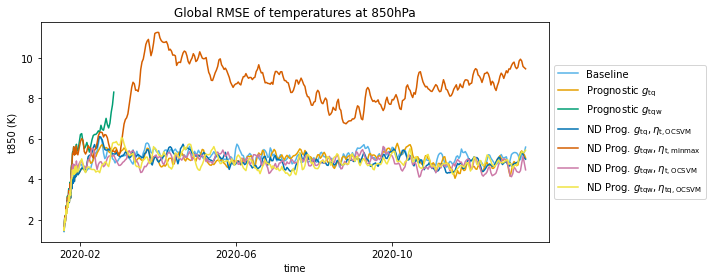

In [21]:
# use xr plots to visualize time vs rmse temp850 
# plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 4), tight_layout=True)
for name, label in table_run_names.items():
    diags_complete[name].tmp850_rms_global.plot(label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel(r"t850 (K)")
plt.title(r"Global RMSE of temperatures at 850hPa")
plt.show()

## Figure {fig: temp-map-plots}

In [129]:
map_plot_names = {
    "baseline": r"Baseline",
    "prognostic": r"Prognostic $g_{\mathrm{Tquv}}$",
    "ocsvm-gamma-4_79-0": r"ND Prog. $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, OCSVM}}$",
}

In [130]:
common_coords = {"tile": range(6), "x": range(48), "y": range(48)}
grid = catalog["grid/c48"].read().assign_coords(common_coords)

In [131]:
temp_biases = xr.concat(
    [diags_complete[name].tmp850_time_mean_bias.assign_coords(common_coords).to_dataset(name="ds") for name in map_plot_names],
    dim=pd.Index(map_plot_names.values(), name="run")
)

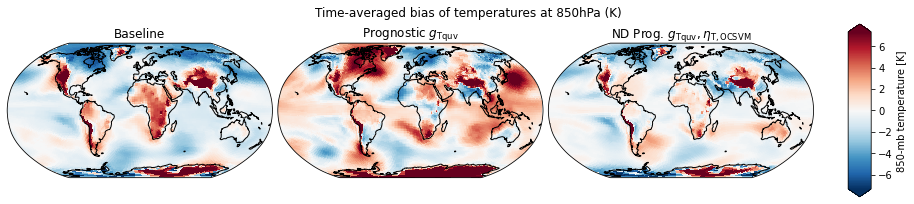

In [135]:
fig, subplots, _, _, _  = fv3viz.plot_cube(
    temp_biases[["ds"]].merge(grid),   
    "ds",
    col="run",
)
for i, title in enumerate(map_plot_names.values()):
    subplots[0][i].set_title(title)
fig.set_size_inches(16, 3)
fig.suptitle("Time-averaged bias of temperatures at 850hPa (K)")
fig.show()


## Table {tab:metrics-thres}

In [26]:
link_table_run_names = {
    "ocsvm-gamma-4_79-0": r"$\psi_{\mathrm{mask}}",
    "ocsvm-gamma-4_79-0-ramp-0.1": r"$\psi_{\mathrm{ramp}, 0.1}",
    "ocsvm-gamma-4_79-0-ramp-0.25": r"$\psi_{\mathrm{ramp}, 0.25}",
    "ocsvm-gamma-4_79-0-ramp-0.5": r"$\psi_{\mathrm{ramp}, 0.5}",
    "ocsvm-gamma-4_79-0-decay-0.25-0.005": r"$\psi_{\mathrm{decay}, 0.25, 0.005}",
    "ocsvm-gamma-4_79-0-decay-0.25-0.01": r"$\psi_{\mathrm{decay}, 0.25, 0.01}",
    "ocsvm-gamma-4_79-0-decay-0.25-0.02": r"$\psi_{\mathrm{decay}, 0.25, 0.02}",
}

In [27]:
for name in table_run_names:
    for metric in table_metrics:
        print(f"{name} {table_metrics}: {metrics[name][metric]}")

baseline ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 2.7333712577819824, 'units': 'K'}
baseline ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.7809481457785814, 'units': 'mm/day'}
baseline ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 2.794926881790161, 'units': 'kg/m**2'}
prognostic-tq ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 2.9101614952087402, 'units': 'K'}
prognostic-tq ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.4266675313387787, 'units': 'mm/day'}
prognostic-tq ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 3.3141133785247803, 'units': 'kg/m**2'}
prognostic ['rmse_of_time_mean/tmp850', 

## Figure {fig:smooth-nd-map}

In [28]:
link_map_plot_names = {
    "ocsvm-gamma-4_79-0": r"$\psi_{\mathrm{mask}}$",
    "ocsvm-gamma-4_79-0-ramp-0.25": r"$\psi_{\mathrm{ramp}, 0.25}$",
    "ocsvm-gamma-4_79-0-decay-0.25-0.01": r"$\psi_{\mathrm{decay}, 0.25, 0.01}$",
}

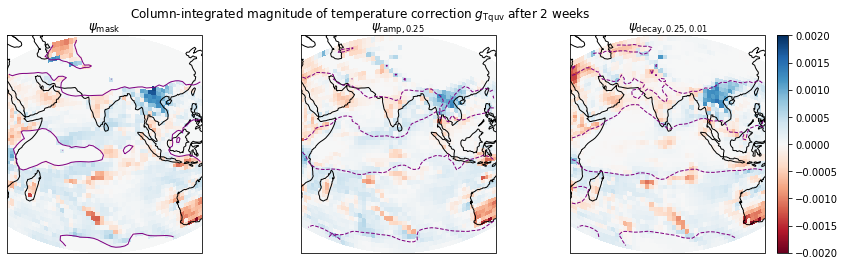

In [173]:
# fig = plt.figure(figsize=(4, 16))
num_weeks = 2
time_freeze = 4 * 7 * num_weeks

link_ds = xr.concat(
    [diags_3d[name].dQ1.isel(time=time_freeze).sum("z").assign_coords(common_coords).to_dataset(name="correction") for name in link_map_plot_names],
    dim=pd.Index(link_map_plot_names.values(), name="run")
)
link_ds = link_ds.merge(grid)

score = xr.concat(
    [diags[name].centered_score.isel(time=time_freeze*2+1).assign_coords(common_coords).to_dataset(name="score") for name in link_map_plot_names],
    dim=pd.Index(link_map_plot_names.values(), name="run")
)
score = score.merge(grid)

cutoffs = [0, -0.25, -0.25]

tile = 1
fig = plt.figure()
for i, title in enumerate(link_map_plot_names.values()):
    ax = plt.subplot(1, 3, i+1, projection=ccrs.Mercator())
    lon = link_ds.lon.isel(tile=tile)
    im = ax.pcolormesh(lon, link_ds.lat.isel(tile=tile), link_ds.correction.isel(tile=tile, run=i), transform=ccrs.PlateCarree(), vmin=-0.002, vmax=0.002, cmap='RdBu')
    ax.contour(lon, score.lat.isel(tile=tile), score.score.isel(tile=tile, run=i), [cutoffs[i]], transform=ccrs.PlateCarree(), linewidths=1, colors="purple")
    # ax.contourf(lon, score.lat.isel(tile=tile), score.score.isel(tile=tile, run=i), [cutoffs[i], 1000000], transform=ccrs.PlateCarree(), colors="yellow", alpha=0.3)
    ax.set_title(title)
    ax.coastlines()
fig.subplots_adjust(right=0.95)
fig.colorbar(im)
fig.set_size_inches(14, 4)
fig.suptitle(r"Column-integrated magnitude of temperature correction $g_{\mathrm{Tquv}}$ after " + str(num_weeks) + r" weeks")
fig.show()


## Figure {fig:temp-explosion}

In [136]:
max_time = 160
time_sl = slice("2020-01-19", "2020-03-30")
table_run_names = {
    "prognostic": r"Prognostic $g_{\mathrm{Tquv}}$",
    "minmax-0": r"ND Prog. $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, minmax}}$",
    "ocsvm-gamma-1_4_79-0": r"ND Prog. $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, OCSVM}}, \gamma=\frac{1}{4 \cdot 79}$",
    "ocsvm-gamma-4_79-0": r"ND Prog. $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, OCSVM}}, \gamma=\frac{4}{79}$",
}


In [137]:
explosion_ds = xr.concat(
    [diags_complete[name].tmp200_zonal_mean_bias for name in table_run_names],
    dim=pd.Index(table_run_names.values(), name="run"),
)

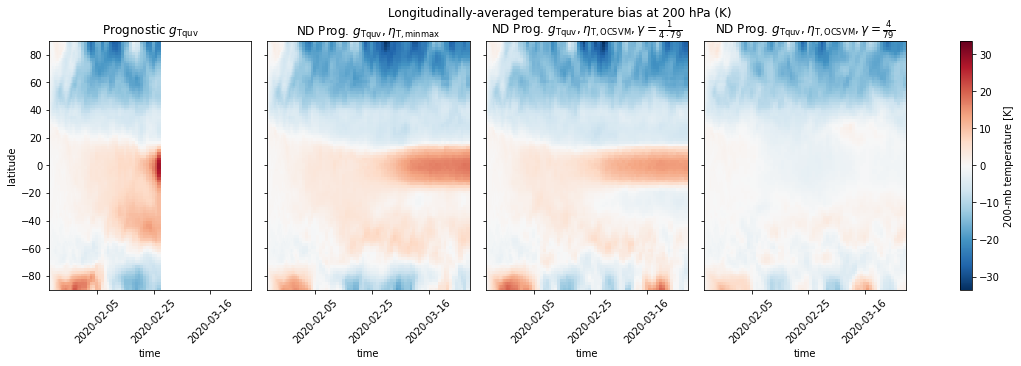

In [155]:
# plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
im = explosion_ds.sel(time=time_sl).plot(col = "run")
# plt.draw()
for i, title in enumerate(table_run_names.values()):
    im.axes[0][i].set_title(title)
    im.axes[0][i].tick_params(axis='x', labelrotation = 45)
im.fig.set_size_inches(16, 5)
# plt.xticks(rotation = 45)
im.fig.suptitle("Longitudinally-averaged temperature bias at 200 hPa (K)")
plt.show()

## Figure {fig:temp-explosion-novelty}

In [139]:
max_time = 160
time_sl = slice("2020-01-19", "2020-03-30")


In [140]:
explosion_novelty_ds = xr.concat(
    [diags_complete[name].is_novelty_zonal_mean_value if name != "prognostic"
    else 0 * diags_complete[name].tmp200_zonal_mean_bias
    for name in table_run_names],
    dim=pd.Index(table_run_names.values(), name="run"),
)

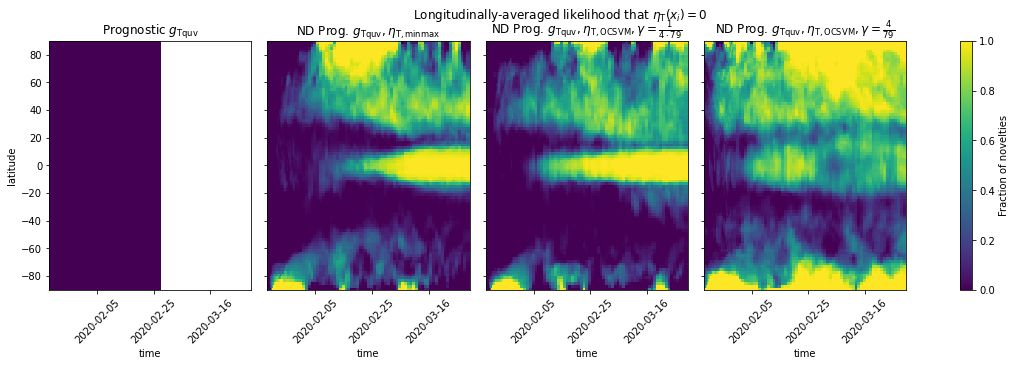

In [156]:
im = explosion_novelty_ds.sel(time=time_sl).plot(col = "run")
for i, title in enumerate(table_run_names.values()):
    im.axes[0][i].set_title(title)
    im.axes[0][i].tick_params(axis='x', labelrotation = 45)
im.fig.set_size_inches(16, 5)
im.fig.suptitle(r"Longitudinally-averaged likelihood that $\eta_{\mathrm{T}}(x_i) = 0$")
im.cbar.set_label("Fraction of novelties")
plt.show()

## Figure {fig:temp-explosion-map}

In [36]:
time_sl_before_crash = slice("2020-01-19", "2020-02-26")

explosion_ds_map = xr.concat(
    [(atmos[name].TMP200 - validation.TMP200).sel(time=time_sl_before_crash).mean("time").rename({"grid_xt": "x", "grid_yt": "y"}).assign_coords(common_coords) for name in table_run_names],
    dim=pd.Index(table_run_names.values(), name="run"),
)

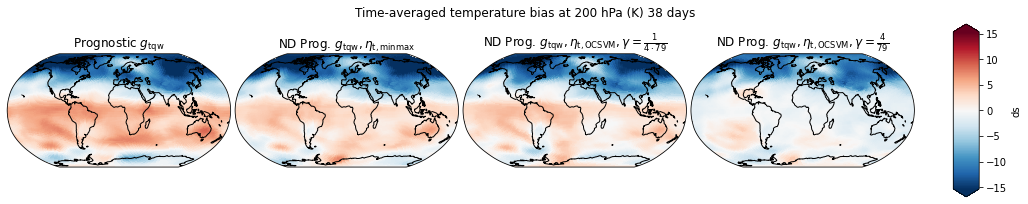

In [37]:
fig, subplots, _, _, _  = fv3viz.plot_cube(
    explosion_ds_map.to_dataset(name="ds").merge(grid),   
    "ds",
    col="run",
)
for i, title in enumerate(table_run_names.values()):
    subplots[0][i].set_title(title)
fig.set_size_inches(18, 3)
fig.suptitle("Time-averaged temperature bias at 200 hPa (K) 38 days")
fig.show()


In [127]:
table_run_novelty_names = {
    "minmax-0": r"ND Prog. $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, minmax}}$",
    "ocsvm-gamma-1_4_79-0": r"ND Prog. $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, OCSVM}}, \gamma=\frac{1}{4 \cdot 79}$",
    "ocsvm-gamma-4_79-0": r"ND Prog. $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, OCSVM}}, \gamma=\frac{4}{79}$",
}

explosion_ds_map_all_time = xr.concat(
    [(atmos[name].TMP200 - validation.TMP200).mean("time").rename({"grid_xt": "x", "grid_yt": "y"}).assign_coords(common_coords) for name in table_run_novelty_names],
    dim=pd.Index(table_run_novelty_names.values(), name="run"),
)

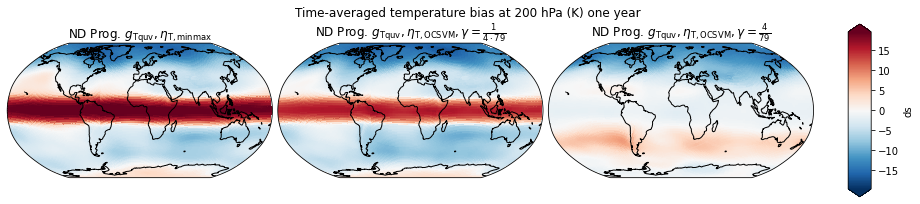

In [128]:
fig, subplots, _, _, _  = fv3viz.plot_cube(
    explosion_ds_map_all_time.to_dataset(name="ds").merge(grid),   
    "ds",
    col="run",
)
for i, title in enumerate(table_run_novelty_names.values()):
    subplots[0][i].set_title(title)
fig.set_size_inches(16, 3)
fig.suptitle("Time-averaged temperature bias at 200 hPa (K) one year")
fig.show()


## Figure {fig:params}

In [163]:
minmax_names = get_names_alg("minmax")
minmax_cutoffs = [runs[i]["cutoff"] for i in runs if i in minmax_names]
ocsvm_large_names = get_names_alg("ocsvm", gamma=4/79)
ocsvm_large_cutoffs = [runs[i]["cutoff"] for i in runs if i in ocsvm_large_names]
ocsvm_default_names = get_names_alg("ocsvm", gamma=1/79)
ocsvm_default_cutoffs = [runs[i]["cutoff"] for i in runs if i in ocsvm_default_names]
ocsvm_small_names = get_names_alg("ocsvm", gamma=1/4/79)
ocsvm_small_cutoffs = [runs[i]["cutoff"] for i in runs if i in ocsvm_small_names]
ocsvm_names = {
    4/79: ocsvm_large_names,
    1/79: ocsvm_default_names,
    1/4/79: ocsvm_small_names
}
ocsvm_cutoffs = {
    4/79: ocsvm_large_cutoffs,
    1/79: ocsvm_default_cutoffs,
    1/4/79: ocsvm_small_cutoffs
}
minmax_names_bp = get_names_alg("minmax", include_bp=True)
ocsvm_large_names_bp = get_names_alg("ocsvm", gamma=4/79, include_bp=True)
ocsvm_default_names_bp = get_names_alg("ocsvm", gamma=1/79, include_bp=True)
ocsvm_small_names_bp = get_names_alg("ocsvm", gamma=1/4/79, include_bp=True)

gamma_strs = {
    4/79: r"$\gamma = \frac{4}{79}$",
    1/79: r"$\gamma = \frac{1}{79}$",
    1/4/79: r"$\gamma = \frac{1}{316}$",
}

metric_strs = ["rmse_of_time_mean/tmp850", "rmse_of_time_mean/total_precip_to_surface", "rmse_of_time_mean/pwat"]
metric_names = ["RMSE T (K)", "RMSE SP (mm/day)", "PWAT (kg/$\mathrm{m}^2)$"]


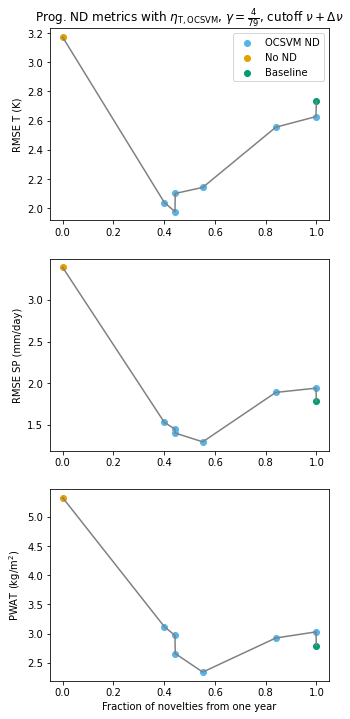

In [167]:

fig = plt.figure(figsize=(5, 12))
# fig.suptitle(f"{metric_str} for {names[i]}")

for i, metric_str in enumerate(metric_strs):

    ax = plt.subplot(3, 1, i+1)

    metric = [metrics[j][metric_str]["value"] for j in ocsvm_large_names]
    metric_bp = [metrics[j][metric_str]["value"] for j in ocsvm_large_names_bp]
    novelty_fracs, metric_bp_online = zip(*sorted(zip([novelty_fractions[name] for name in ocsvm_large_names_bp], metric_bp)))
    ax.plot(novelty_fracs, metric_bp_online, c="gray")
    ax.scatter([novelty_fractions[name] for name in ocsvm_large_names], metric, label="OCSVM ND")
    ax.scatter([novelty_fractions["prognostic"]], [metrics["prognostic"][metric_str]["value"]], label="No ND")
    ax.scatter([novelty_fractions["baseline"]], [metrics["baseline"][metric_str]["value"]], label="Baseline")
    ax.set_ylabel(metric_names[i])
    if i == 0:
            ax.set_title(r"Prog. ND metrics with $\eta_{\mathrm{T, OCSVM}}$, " +  gamma_strs[4/79] + r", cutoff $\nu + \Delta \nu$")
            plt.legend()
    if i == 2:
        ax.set_xlabel("Fraction of novelties from one year")

plt.show()

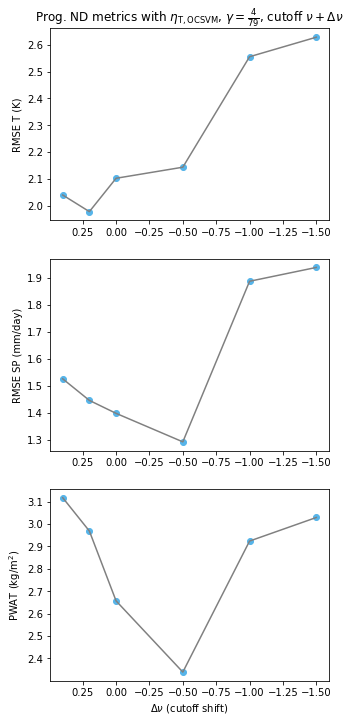

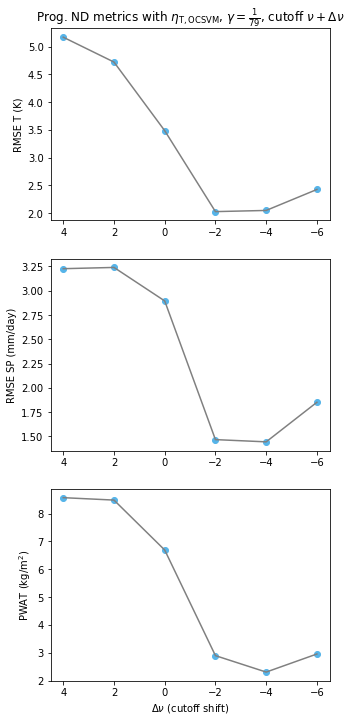

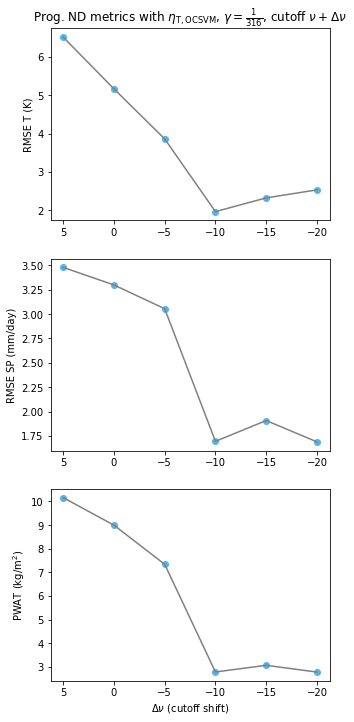

In [168]:

for gamma in [4/79, 1/79, 1/4/79]:

    fig = plt.figure(figsize=(5, 12))

    for i, metric_str in enumerate(metric_strs):
        ax = plt.subplot(3, 1, i+1)

        metric = [metrics[j][metric_str]["value"] for j in ocsvm_names[gamma]]
        ax.scatter(ocsvm_cutoffs[gamma], metric)
        ax.plot(ocsvm_cutoffs[gamma], metric, c="gray")
        ax.invert_xaxis()
        ax.set_ylabel(metric_names[i])
        if i == 0:
            ax.set_title(r"Prog. ND metrics with $\eta_{\mathrm{T, OCSVM}}$, " +  gamma_strs[gamma] + r", cutoff $\nu + \Delta \nu$")
        if i == 2:
            ax.set_xlabel(r"$\Delta \nu$ (cutoff shift)")

    # plt.suptitle(r"Metrics for Prog. ND with $\eta_{\mathrm{t, OCSVM}}$, cutoff $\nu + \Delta \nu$")
    plt.show()

In [ ]:
metrics[""]